In [2]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# def Camera Calibration

In [3]:
def camera_calibration(folder,nx,ny,showMe=0):
    objpoints = []#3D
    imgpoints = []
    objp = np.zeros((nx*ny,3),np.float32)
    #print(objp.shape)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)   
    assert len(folder)!=0
    for fname in folder:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(nx,ny))
        img_sz = gray.shape[::-1]
        #print(corners)
        #if ret is True , find corners
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            if showMe:
                draw_corners = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
                display(draw_corners,'Found all corners:{}'.format(ret))
    if len(objpoints)==len(imgpoints) and len(objpoints)!=0:
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_sz,None,None)
        return {'ret':ret,'cameraMatrix':mtx,'distorsionCoeff':dist,\
               'rotationVec':rvecs,'translationVec':tvecs}
    else:
        raise  Error('Camera Calibration failed')
def correction(image,calib_params):
    corrected = cv2.undistort(image,calib_params['cameraMatrix'],calib_params['distorsionCoeff'],\
                              None,calib_params['cameraMatrix'])
    return corrected

RMS Error of Camera calibration:1.030
This number must be between 0.1 and 1.0


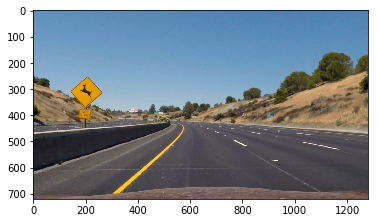

In [4]:
folder=glob.glob('camera_cal/calibration*.jpg')
folder_calibration = glob.glob("camera_cal/calibration*.jpg")
nx,ny=9,6
calib_params = camera_calibration(folder_calibration,nx,ny,showMe=0)
print('RMS Error of Camera calibration:{:.3f}'.format(calib_params['ret']))
print('This number must be between 0.1 and 1.0')
imgs_tests = glob.glob("test_images/*.jpg")
original_img = cv2.imread("test_images/test2.jpg")
original_img = cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB)
corr_img = correction(original_img,calib_params)
plt.imshow(corr_img)
plt.savefig('output_images/test2_corrected.jpg')

# perspective Transform

In [5]:
def unwarp(img):
    offset=150
    h,w=img.shape[:2]
    src = np.float32([(250,680),
                  (1045,680), 
                  (702,459), 
                  (582,459)])
    dst = np.float32([(offset,h),
                      (w-offset,h),
                      (w-offset,0),
                      (offset,0)])
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
print('...')

...


In [6]:
warped,M,Minv=unwarp(corr_img)

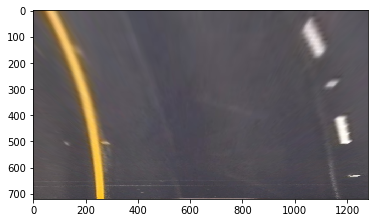

In [7]:
plt.imshow(warped)
#plt.savefig('output_images/test2_warped.jpg')

# HLS S_channel Threshold 

In [8]:

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


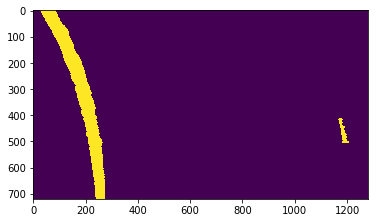

In [9]:
binary_s=hls_sthresh(warped,(90,255))
plt.imshow(binary_s)

# Sobel direction

In [10]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img,orient,thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
print('...')

...


In [11]:
binary_x=abs_sobel_thresh(warped,'x',(30,255))

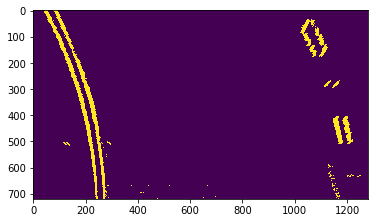

In [12]:
plt.imshow(binary_x)

# Sobel Magnitude Threshold

In [13]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel, mag_thresh):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output
print('...')

...


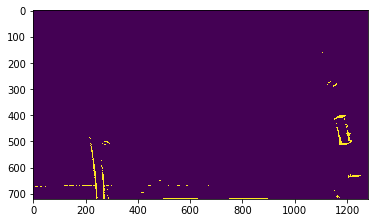

In [14]:
binary_magn=mag_thresh(warped,25,(30,255))
plt.imshow(binary_magn)

# combin Binary

In [15]:
def binary_final(binary_x,binary_s):
    out=np.zeros_like(binary_x)
    out[(binary_x==1)|(binary_s==1)]=1
    return out
print('...')


...


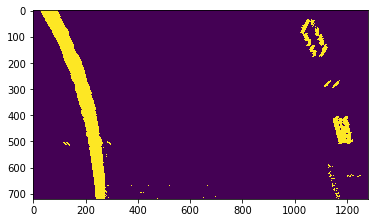

In [16]:
final_binary=binary_final(binary_x,binary_s)
plt.imshow(final_binary)
#plt.savefig('output_images/final_binary.jpg')

# sliding window polyfit

In [17]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
    out_img=np.dstack((img,img,img))
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 3)
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds,histogram,out_img
print('...')

...


In [18]:
left_fit1,right_fit1,left_lane_inds,right_lane_inds,hist,out=sliding_window_polyfit(final_binary)

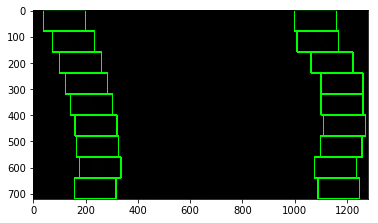

In [19]:
plt.imshow(out)

# show the Windows and lane line

In [20]:
def fit_polynomial(img):
    # Find our lane pixels first
    left_fit, right_fit, left_lane_inds, right_lane_inds,hist,out= sliding_window_polyfit(img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    nonzero=np.nonzero(img)
    nonzerox=nonzero[1]
    nonzeroy=nonzero[0]
    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds]
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds]
    out[lefty, leftx] = [255, 0, 0]
    out[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out,left_fit,right_fit,left_lane_inds,right_lane_inds
    print('...')

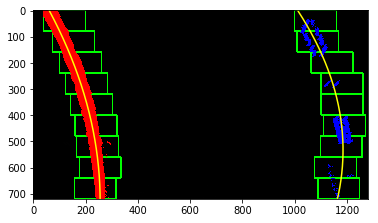

In [21]:
out,l,r,lli,rli=fit_polynomial(final_binary)
plt.imshow(out)
#plt.savefig('output_images/demo_windows.jpg')

# Polyfit using Fit from Previouse Frame

In [22]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(img, left_fit_prev, right_fit_prev,show):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    if show:
        ploty=np.linspace(0,img.shape[0]-1,img.shape[0])
        left_fitx=left_fit_new[0]*ploty**2+left_fit_new[1]*ploty+left_fit_new[2]
        right_fitx=right_fit_new[0]*ploty**2+right_fit_new[1]*ploty+right_fit_new[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))
        window_img = np.zeros_like(out_img)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
        
        
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds,out_img
print('...')

...


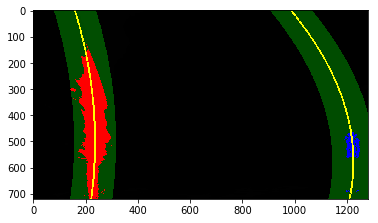

In [23]:
img2=cv2.imread('test_images/test4.jpg')
original_img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
corr_img2 = correction(original_img2,calib_params)
warped2,M2,Minx2=unwarp(corr_img2)
binary_x2=abs_sobel_thresh(warped2,'x',(50,255))
binary_s2=hls_sthresh(warped2,(90,255))
final_binary2=binary_final(binary_x2,binary_s2)
l2,r2,lli2,rli2,out=polyfit_using_prev_fit(final_binary2,left_fit1,right_fit1,1)
plt.imshow(out)
plt.savefig('output_images/detection_baseOf_previous ')

# Radius of Curvature and Distance from Lane Center

In [46]:
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h,w= bin_img.shape[0],bin_img.shape[1]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        if r_fit is not None and l_fit is not None:
            car_position= w/2
            l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
            r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
            lane_center_position = (r_fit_x_int + l_fit_x_int) /2
            center_dist = (car_position - lane_center_position) * xm_per_pix
            return left_curverad,right_curverad,center_dist
    print('...')

In [47]:
rad_l,rad_r,d_center=calc_curv_rad_and_center(final_binary,left_fit1,right_fit1,left_lane_inds,right_lane_inds)

# Draw the Deteckted Lane and Curvature onto the Original Img

In [48]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


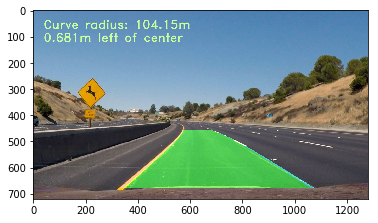

In [49]:
out_put1=draw_lane(original_img,final_binary,left_fit1,right_fit1,Minv)
out_put2=draw_data(out_put1,(rad_l+rad_r)/2,d_center)
plt.imshow(out_put2)

# total Process

In [52]:
def Img_process(img):
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    corr_img = correction(img,calib_params)
    warped,M,Minv=unwarp(corr_img)
    binary_x=abs_sobel_thresh(warped,'x',(30,255))
    binary_s=hls_sthresh(warped,(90,255))
    final_binary=binary_final(binary_x,binary_s)
    out,left_fit,right_fit,left_lane_inds,right_lane_inds=fit_polynomial(final_binary)
    rad_l,rad_r,d_center=calc_curv_rad_and_center(final_binary,left_fit,right_fit,left_lane_inds,right_lane_inds)
    out_put1=draw_lane(corr_img,final_binary,left_fit,right_fit,Minv)
    out_put2=draw_data(out_put1,(rad_l+rad_r)/2,d_center)
    return out_put2

In [1]:
img=cv2.imread('test_images/test1.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
out_put=Img_process(img)
plt.imshow(out_put)
plt.savefig('output_images/test3_out.jpg')

NameError: name 'cv2' is not defined

In [ ]:
video_output1='project_video_output.mp4'
video_input1=VideoFileClip('project_video.mp4')
processed_video=video_input1.fl_image(Img_process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:14<00:00,  3.99it/s]


In [54]:
video_output1='challenge_video_output.mp4'
video_input1=VideoFileClip('challenge_video.mp4')
processed_video=video_input1.fl_image(Img_process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:49<00:00,  4.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 53.6 s, sys: 9.68 s, total: 1min 3s
Wall time: 1min 52s


In [80]:
video_output1='harder_challenge_video_output.mp4'
video_input2=VideoFileClip('harder_challenge_video.mp4')
processed_video=video_input2.fl_image(Img_process)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [05:48<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 2min 42s, sys: 23.2 s, total: 3min 6s
Wall time: 5min 52s
